<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="left"; style="background-color:transparent; width: 33%;"><a href="https://www.inrae.fr"><img src="https://www.inrae.fr/themes/custom/inrae_socle/logo.svg" width="40%"></a></td>
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/DATAIA-h.png" width="80%"></a></td>
    <td align="right"; style="background-color:transparent; width: 33%;"><a href="https://www.vet-alfort.fr/"><img src="https://www.vet-alfort.fr/images/logo-enva.svg" width="55%"></a></td>
  </tr>
</table> 
</div>

<center><h1>Bovine Embryos Movies challenge</h1></center>

<center><h3>A data challenge on early prediction of the fate of bovine embryos</h3></center>
<br/>
<center><i>Julien Chiquet (MIA Paris-Saclay, Inrae), Pierre Gloaguen (MIA Paris-Saclay, AgroParisTech), Nicolas Jouvin (MIA Paris-Saclay), Patrick Bouthemy (SERPICO, Inria), Alain Truibil (MaiAGE, Inrae), Alline Reis (PASP, ENVA), François Caud, Alexandre Gramfort (DATAIA, Univ. Paris-Saclay) </i></center>

# 1. Introduction 


This challenge consists in predicting the developmental state of bovine embryos seen at 192 hours after fertilisation (HAF). There are 8 different classes (denoted from "A" to "H" in this challenge) corresponding to biological states from alive ("A") to dead ("H").

The known labels are the developmental state of the embryos at 192 HAF. The goal of this challenge is to predict the future embryo state at 192 HAF using only information available between 27 and 94 HAF (at latest). The  dataset consists in 277 videos from INRAE's database. Each video is a timelapse of an embryo's development consisting in 300 frames taken every fifteen minutes. We want to predict the 192 HAF's label at 10 different times, namely 27, 32, 37, 40, 44, 48, 53, 58, 63, 94 hours after fertilization. 

The biological labels at 192 HAF are expert-based and use both the final state of the embryos (*i.e* the final frame) but also the whole video dynamics. Therefore, it might be important to take into account the succession of frames for good classification performances.

**Note about the prediction times:** Due to experimental conditions, the first frame is recorded at a time t0 ($t_0$) that might vary between videos. The timestamp information of each frame in each video is available and accessible. The predicting model will aim at predicting at specific *times* (and not frame numbers).

**Note about the diffusion of the data:** Any communication from this challenge must be authorized by the owners of the Database before publication.

<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">    
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/logos/challenge_image.png" width="80%"></a></td>
    
</table> 
</div>

<center><b>Fig.1 - Description of two video data for this challenge. The green part covers from 24 to 94 HAF while the whole video (green & yellow) ends at 192 HAF and was watched by an expert to design the label (blue). The challenge consists in predicting blue having only access to the green part for training and testing.  </b></center>


## Setup

### Prerequisites

The following cell will install the required package dependencies, if necessary. You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

In [1]:
import numpy as np

> **NOTE:** Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added to be added via a pull request to the [GitHub repo](https://github.com/ramp-kits/bovinsembryos).

Install the `ramp-workflow` package from PyPI using the following command in you dedicated python environment.

```pip install ramp-workflow```

### The problem.py file

This file contains the definition of the data-challenge according to the RAMP framework. In addition, it contains some useful methods and class.

In [2]:
from problem import get_train_data, get_test_data, WeightedClassificationError

## Downloading the data

The public data are stored in a public OSF repository, you only need to run the following script which create the `data/` repository locally.

> Note that, in order to be registered to the RAMP studio event, partiticipants must fill the [following form](https://framaforms.org/access-request-to-the-bovmovies2pred-data-challenge-osf-dataset-1646386323) which contain an agreement on the use of the data.

```python download_data.py```

In [3]:
!python download_data.py

/home/mratet/PycharmProjects/Classification-Cell-Videos/data directory is not empty. Please empty it or select another destination for LOCAL_DATA if you wish to proceed


# Data exploration <a name=data_exp></a>

### Loading the data

First, we load the data using the utility function designed for the challenge in `problem.py`. 

In [4]:
videos_train, labels_train = get_train_data()

`labels_trains` simply consists in the set of labels for the training set, stored as a `numpy.darray`

In [5]:
print(labels_train[:10])
print(labels_train.shape)
print('Number of videos in the training set: {}'.format(labels_train.size))

['H' 'H' 'A' 'F' 'H' 'A' 'A' 'F' 'F' 'A']
(177,)
Number of videos in the training set: 177


On the other hand `videos_train` is a list of objects from the class `VideoReader`. This class is fully described below.

In [6]:
print(type(videos_train)) # List
print(type(videos_train[0])) # VideoReader object (see below)

<class 'list'>
<class 'problem.VideoReader'>


### Data visualization 

A video is timelapse of the embryos development, with one image every 15 minutes. One may plot a video image at a specific time (expressed in hour) via the `read_frame` helper method (described below).

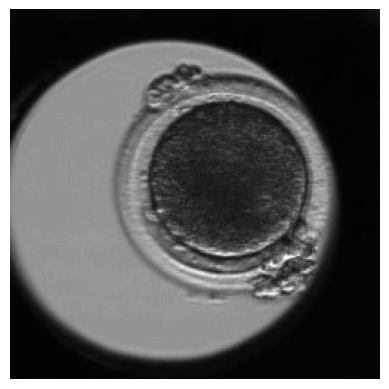

In [7]:
import matplotlib.pyplot as plt
# Here, we use the read_frame method to extract a specific time
# See below for the description of this method
plt.imshow(videos_train[20].read_frame(frame_time=24), cmap='gray')
plt.axis('off')
plt.show()

Additionaly, one can plot the video's dynamics between two given times with the `plot_sequence` method. However, in order to better visualize  the dynamics we recommand using a dedicated video software such as VLC.

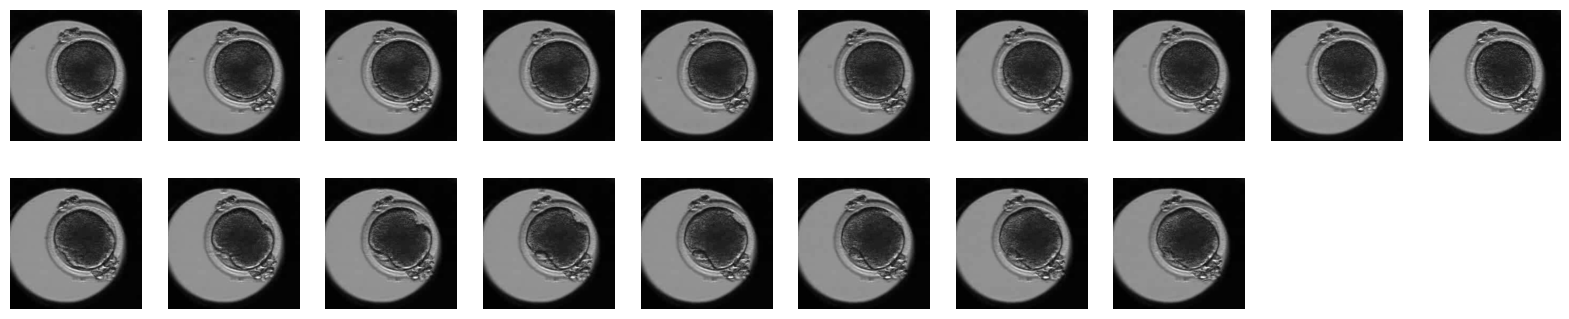

In [8]:
videos_train[20].plot_sequence(27., 31.25)

One may also inspect the class distribution among the 8 possible categories

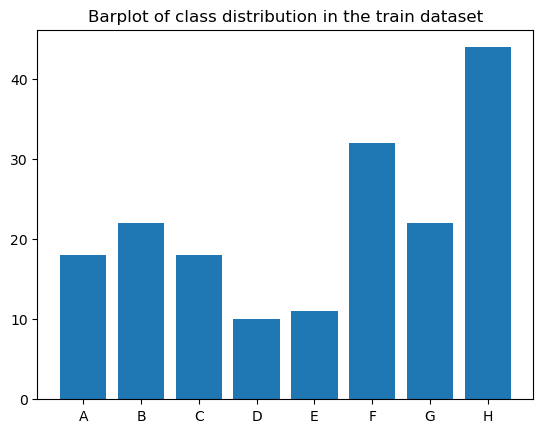

In [9]:
labs, counts = np.unique(labels_train, return_counts=True)
plt.bar(labs, counts)
plt.title("Barplot of class distribution in the train dataset")
plt.show()

Notice that the class are imbalanced on this dataset, with few examples per class. Although the starting kit does not use them, data augmentation as well as oversampling might be advised. 

## The VideoReader class

The `VideoReader` class aims at manipulating the videos. It is basically a wrapper for some openCV features of the library `cv2`, and its main aim is to ease the manipulation of videos for the participants. It is implemented in the `problem.py` file, still we copy its definition here for the sake of self-completeness.

In [10]:
# You can import the VideoReader class from problem.py via
from problem import VideoReader

In [11]:
import cv2

class VideoReader:
    def __init__(self, video_filename, frame_times, img_size=[250, 250]):
        self.video = cv2.VideoCapture(video_filename)
        self.nb_frames = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        self.img_size = img_size
        self.frame_times = frame_times

    def read_frame(self, frame_time):
        """Return the frame of a VideoReader object at the specified `frame_time`

        Args:
            frame_time (float): the specified time in hours (allowing quarter hours, e.g. 25.75 or 26.50)

        Raises:
            ValueError: If the specified time does not exist for the selected video

        Returns:
            np.ndarray: A 2-D array containing the grayscale image. 
        """
        if frame_time not in self.frame_times:
            raise ValueError('The specified frame time must me within the time '
                             'interval of the video.')

        frame_nb = np.where(self.frame_times == frame_time)[0][0]
        if frame_nb is not None:
            self.video.set(cv2.CAP_PROP_POS_FRAMES, frame_nb)
        _, frame = self.video.read()

        # always reset video's frame counter to 0 to avoid unexpected behavior
        self.video.set(cv2.CAP_PROP_POS_FRAMES, 0)

        return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    def read_sequence(self, begin_time=None, end_time=None):
        """Extract the sequence of consecutive frames from begin_time to end_time (included)

        Args:
            begin_time (float, optional): The time where the extraction begins. Defaults to None.
            end_time (float, optional):  The time where the extraction ends. Defaults to None.

        Returns:
            np.ndarray: A 3-D numpy array with first axis corresponding to the frame index and the remaining dimension to image size.
        """
        if begin_time is None:
            begin_time = self.frame_times[0]
        elif begin_time not in self.frame_times:
            raise ValueError('The specified begin_time must me within the time'
                             ' interval of the video.')

        if end_time is None:
            end_time = self.frame_times[-1]
        elif end_time not in self.frame_times:
            raise ValueError('The specified end_time must me within the time '
                             'interval of the video.')

        if begin_time > end_time:
            raise ValueError("begin_time must be smaller than end_time.")

        begin_nb = np.where(self.frame_times == begin_time)[0][0]
        end_nb = np.where(self.frame_times == end_time)[0][0]
        self.video.set(cv2.CAP_PROP_POS_FRAMES, begin_nb)

        my_frames = list(range(begin_nb, end_nb + 1))
        video_array = np.empty(
            shape=(len(my_frames), self.img_size[0], self.img_size[1])
        )
        for t, _ in enumerate(my_frames):
            _, frame = self.video.read()
            video_array[t, :, :] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # always reset video's frame counter to 0 to avoid unexpected behavior 
        self.video.set(cv2.CAP_PROP_POS_FRAMES, 0)

        return video_array

    def read_samples(self, selected_times=None):
        """Read several frames of the video at once corresponding to the selected times.

        Args:
            selected_times (list, optional): The list of of desired extraction times, in hours (allowing quarter hour). Defaults to None, the whole 300 frames are returned.

        Returns:
            np.ndarray: A 3-D numpy array with of shape (size len(selected_times), 250, 250).
        """
        if selected_times is None:
            selected_times = self.frame_times

        res = np.empty([len(selected_times), self.img_size[0], self.img_size[1]])
        frame_nbs = np.where([t in selected_times for t in self.frame_times])[0]
        for i, f in enumerate(frame_nbs):
            self.video.set(cv2.CAP_PROP_POS_FRAMES, f)
            _, frame = self.video.read()

            res[i, :, :] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        self.video.set(cv2.CAP_PROP_POS_FRAMES, 0)

        return res
    
    def plot_sequence(self, begin_time=None, end_time=None, fig_width=20.0):
        """Plots the result of read_sequence.

        Args:
            begin_time (float, optional): The time where the extraction begins.
            Defaults to None.
            end_time (float, optional):  The time where the extraction ends.
            Defaults to None.
            fig_width (float, optional): The total figure width, height is
            adapted automatically.

        Returns:
            None (but displays the matplotlib figure).
        """
        vid_arr = self.read_sequence(begin_time, end_time)
        n_vids = vid_arr.shape[0]

        # Create subplots of 10 columns
        num_cols = 10
        num_rows = int(n_vids // num_cols)
        num_rows = num_rows + 1 if n_vids % num_cols != 0 else num_rows

        fig_height = fig_width * num_rows / num_cols

        fig = plt.figure(figsize=(fig_width, fig_height))
        for i in range(1, num_rows * num_cols + 1):
            if i - 1 >= n_vids:
                break
            img = vid_arr[i - 1]
            fig.add_subplot(num_rows, num_cols, i)
            plt.imshow(img, cmap="gray")
            plt.axis("off")

        plt.show()

### Attributes

The `VideoReader` class has 3 attributes illustrated in the next cell :
- `video`: the video object, which is as cv2.VideoCapture (see [the documentation](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html))
- `nb_frames`: the number of frames. This should be 300 for each video.
- `frame_times`:  a 1-D `numpy.array` containing the times at which the frames where recorded. These times are expressed in hours since the fecondation. **All frames** are separated by 15 mns (0.25 hours). However, due to different experimental conditions, videos **might start at different times**!
- `img_size` returns the dimensions of the square images composing the video. This should be normalized to $250 \times 250$.



In [12]:
example_video = videos_train[0]
print("A video is stored as a " + str(type(example_video.video)) + " Python object.")
print("It has " + str(example_video.nb_frames) + " frames of size " + str(example_video.img_size) + ".")
print("The frame are recorded at the following times (expressed as time in hour since the fecondation)")
print(example_video.frame_times[0:30])

A video is stored as a <class 'cv2.VideoCapture'> Python object.
It has 300 frames of size [250, 250].
The frame are recorded at the following times (expressed as time in hour since the fecondation)
[23.75 24.   24.25 24.5  24.75 25.   25.25 25.5  25.75 26.   26.25 26.5
 26.75 27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5
 29.75 30.   30.25 30.5  30.75 31.  ]


### Methods
The `VideoReader` class has methods illustrated in the next cell :
- The `read_frame` method returns the frame of the video at a specified time.  The user must provide the `frame_time` argument, which is a time present in the `frame_times` attribute. This method returns a 2-D `numpy.ndarray`.
- The `read_sequence` method returns a sequence of **consecutive frames**. The user must provide the `begin_time` argument (the frame time at which the sequence begins) and the `end_time` (the frame time at which the sequence ends). By default, these two arguments are set to `None`, which results in starting at first time and ending at last time. The method returns a 3-D ($n \times 250 \times 250$) `numpy.ndarray`, where $n$ is the number of consecutive times between `begin_time` and `end_time` (included).
- The `read_samples` method transforms the video to a 3-D ($300 \times 250 \times 250$) `numpy.ndarray`. Optionally, a `selected_times` argument (provided as a list) may be specified to only select frames corresponding to these times.
- The `plot_sequence` method plots the output of `read_sequence`, *i.e.* the consecutive frames to display video dynamics. However, the video are best visualized in a dedicated software like VLC. Agai, the user must provide the `begin_time` argument (the frame time at which the sequence begins) and the `end_time` (the frame time at which the sequence ends).

Plot the videos frames corresponding to times: [23.75 73.75 98.5 ] hours.


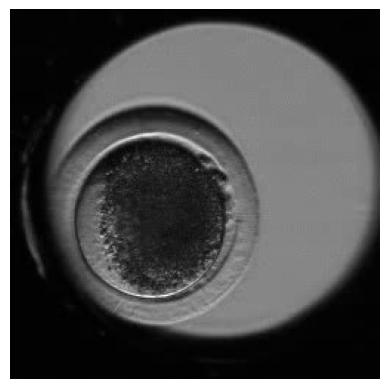

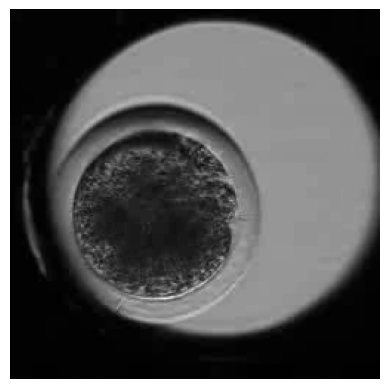

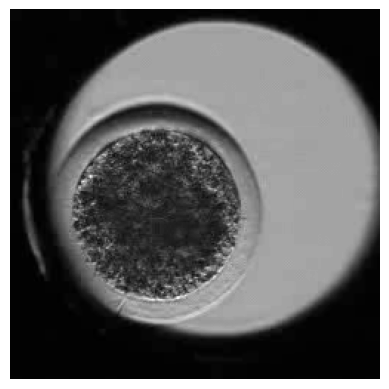

In [13]:
selected_times = example_video.frame_times[[0, 200, 299]] 
print("Plot the videos frames corresponding to times: " + str(selected_times) + " hours.")
for frame_time in selected_times:
    plt.imshow(example_video.read_frame(frame_time), cmap="gray")
    plt.axis('off')
    plt.show()

In [14]:
video_array = example_video.read_sequence()
video_array.shape

(300, 250, 250)

In [15]:
video_array = example_video.read_sequence(end_time = 29)
print(video_array.shape)

video_array = example_video.read_sequence(begin_time = 28.75, end_time=29)
print(video_array.shape)

(22, 250, 250)
(2, 250, 250)


In [16]:
video_array = example_video.read_samples(selected_times=[23.75, 62.25, 96])
video_array.shape

(3, 250, 250)

> **Caution:** the VideoReader class does not load all the videos frame into memory, which is useful in order not to overload you local machine or the RAMP servers. However, the `read_sample` or `read_sequence` may quickly lead to memory issues when trying to load every videos. You code should take this issue into account and treat videos sequentially or, at least, batch-wise.

In [17]:
# DO NOT TRY TO RUN (memory will collapse)
# data = []
# for video in videos_train:
#     data.append(data.read_samples())

# Designing a submission

### Evaluation

For the moment, we only consider the overall classification accuracy of your classifiers.

Locally, the RAMP platform use a 3-fold cross-validation scheme implemented for you in the `get_cv` method. Moreover, the classifier's performance is evaluated on a separate test set which can be loaded just as the training data. 

In [18]:
videos_test, labels_test  = get_test_data()

In [19]:
print('Number of subjects in the test set: {}'.format(labels_test.size))

Number of subjects in the test set: 100


### Handling several prediction times

Remember that the challenge's objective is to design classifier(s) for different prediction times between 1 and 4 days (24 to 96 hours). Your submission should account for that constraints with a `pred_time` argument for the model fit and prediction, ensuring that only frames up to `pred_times` are used for model training and testing.

The predefined and fixed prediction times are

In [20]:
pred_times = [27, 32, 37, 40, 44, 48, 53, 58, 63, 94]


where `None` defaults to the use of the whole 300 frame for each video.

> **Important:** You are freed to opt for having one model for each prediction time, or one model for every time. However, note that for the second option your model will be fully retrained at each prediction time, and that it must handle videos with a varying number of frames.

### Mandatory structure of a submission


A submission (usually stored in `./subsmissions/<submission_foldername>/`) must contain on file named `videoclassifier.py`.

This python script must itself implement at least a `VideoClassifier` class with
 * A `fit(videos, y, pred_time)` method.
 * A `pred(videos, pred_time)` method.

The two arguments must be understood as follow:
 * `videos` is a list of `VideoReader` object with videos object cut at `pred_times`.
 * `y` is a 1-D numpy array containing the associated training labels.
 * `pred_time` is the time of development for which the prediction shall be made. 

We illustrate this below with a simple example.




### Illustration : a dummy random classifier

This classifier does not use (nor even load into memory) the videos or the prediction time, and just predict random labels. Still, it is a valid (albeit unuseful) submission regarding the RAMP workflow.

It is implemented in the `./subsmissions/starting_kit/` folder and we copy its code here for illustration.

In [21]:
import numpy as np


class VideoClassifier(object):
    def __init__(self):
        pass

    def fit(self, videos: list, y, pred_time: float):
        classes = ["A", "B", "C", "D", "E", "F", "G", "H"]
        self.n_classes = len(classes)
        pass

    def predict(self, videos: list, pred_time: float):
        proba = np.random.rand(len(videos), self.n_classes)
        proba /= proba.sum(axis=1)[:, np.newaxis]
        return proba

In [22]:
my_pred_time = 94
my_model = VideoClassifier()
my_model.fit(videos_train, labels_train, pred_time=my_pred_time)
y_pred = my_model.predict(videos_test, pred_time=my_pred_time)

#### Score function

For a a given prediction time (in HAF) your prediction score will be a classification **error**: the LOWER the better. Moreover, not all mistakes costs the same for this problem, as some classes are more "distinct" than others. Thus, we use a weight matrix $W$ where the weights were determined by an expert and we give the matrix $W$ below.

The formula of the weighted classification error for a hard label $y_i \in \{1, ..., K\}$ and a hard-prediction $\hat{y}_i \in \{ 1, ..., K \}$ is:

$$
    WCE(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n W_{y_i,\hat{y}_i} 
$$

In practice, your model may output a probability of each label for observation $i$: $\hat{p}_i = (\hat{p}_{ik})_{k=1, \ldots, K} $. The prediction $\hat{y}_i$ is then obtained as $\arg\max_k \hat{p}_{ik}$.

##### Weight matrix $W$

> Note: The weight $W$ could be used to implement your own objective function.

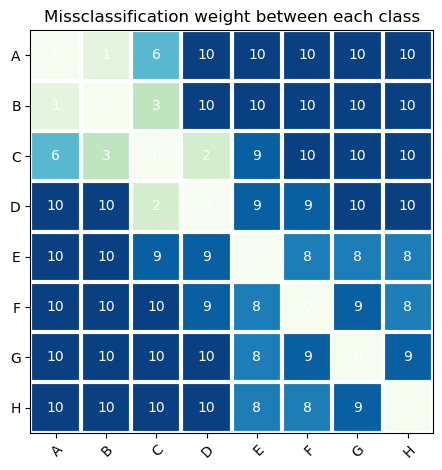

In [23]:
W = np.array(
    [
        [0, 1, 6, 10, 10, 10, 10, 10],
        [1, 0, 3, 10, 10, 10, 10, 10],
        [6, 3, 0, 2, 9, 10, 10, 10],
        [10, 10, 2, 0, 9, 9, 10, 10],
        [10, 10, 9, 9, 0, 8, 8, 8],
        [10, 10, 10, 9, 8, 0, 9, 8],
        [10, 10, 10, 10, 8, 9, 0, 9],
        [10, 10, 10, 10, 8, 8, 9, 0],
    ]
)

labels = ["A", "B", "C", "D", "E", "F", "G", "H"]
fig, ax = plt.subplots()
im = ax.imshow(W, cmap="GnBu")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, W[i, j],
                       ha="center", va="center", color="w")

# space between tiles
ax.set_xticks(np.arange(8+1)-.5, minor=True)
ax.set_yticks(np.arange(8+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

ax.set_title("Missclassification weight between each class")
fig.tight_layout()
plt.show()

##### Score of the dummy random classifier



In [24]:
from sklearn.preprocessing import OneHotEncoder

# we need to convert labels (str) to 1-hot encoding (n, 8) 
labels_test = labels_test.reshape(-1, 1)
enc = OneHotEncoder()
enc.fit(labels_test)
y_true = (enc.transform(labels_test))

# Example of 1-hot encoding for the 10 first test points
print(np.hstack([labels_test[:10], y_true.todense()[:10, :]]))

[['A' 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 ['A' 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 ['G' 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0]
 ['A' 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 ['F' 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0]
 ['C' 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0]
 ['H' 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 ['C' 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0]
 ['C' 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0]
 ['H' 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]]


In [25]:
y_true = y_true.toarray() # add .toarray() to fix an error below
wce = WeightedClassificationError(time_idx=my_pred_time)
wce.compute(y_true=y_true , y_pred=y_pred)

0.701

In [26]:
err = np.zeros((len(pred_times),))
all_preds = []
for time_idx, my_pred_time in enumerate(pred_times):
    my_model = VideoClassifier()
    my_model.fit(videos_train, labels_train, pred_time=my_pred_time)
    y_pred = my_model.predict(videos_test, pred_time=my_pred_time)
    all_preds.append(y_pred)
    wce = WeightedClassificationError(time_idx=time_idx)
    err[time_idx] = wce.compute(y_true=y_true, y_pred=y_pred)
    print(wce.name, ' at time', my_pred_time, 'is:', err[time_idx])

all_preds = np.concatenate(all_preds, axis=1)

WeightedClassificationError[1]  at time 27 is: 0.769
WeightedClassificationError[2]  at time 32 is: 0.767
WeightedClassificationError[3]  at time 37 is: 0.789
WeightedClassificationError[4]  at time 40 is: 0.7080000000000001
WeightedClassificationError[5]  at time 44 is: 0.8220000000000001
WeightedClassificationError[6]  at time 48 is: 0.769
WeightedClassificationError[7]  at time 53 is: 0.7930000000000001
WeightedClassificationError[8]  at time 58 is: 0.812
WeightedClassificationError[9]  at time 63 is: 0.7369999999999999
WeightedClassificationError[10]  at time 94 is: 0.8230000000000001


##### The ranking method on RAMP-board

The error is computed for a given time $t$ and a given prediction $\hat{p}_i^{(t)}$. A submission will then have $10$ different scores that need to be aggregated in order to rank participants. The chosen method is the *Area Under the Curve* (AUC) of the loss evolution over time.

Text(0.5, 1.0, 'Evolution of the error with the prediction time (in HAF)')

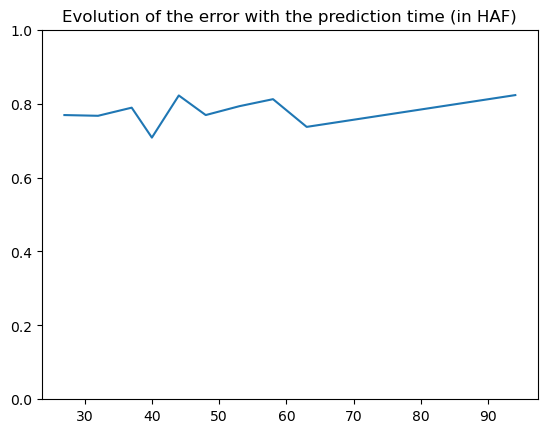

In [27]:
plt.figure()
plt.plot(pred_times, err) 
plt.ylim(0, 1)
plt.title("Evolution of the error with the prediction time (in HAF)")

In [28]:
from problem import AreaUnderCurveError

auc = AreaUnderCurveError(score_func_name="classification", prediction_times=pred_times)

auc.compute(y_true=y_true, y_pred=all_preds)

0.7789179104477613

The pred_times are normalized in the AUC computation, in order to have a loss between 0 and 1. 

### Performance of a deterministic classifier

To compare to the performance of a (dummy) classifier, returning only one of the 8 classes

In [29]:
n_test = y_true.shape[0]
for k in range(8):
    y_k = np.zeros(y_true.shape)
    y_k[range(n_test), k] = 1 
    print(
        'Classifying all videos in class', k, 
        'gives a score of:', wce.compute(y_true=y_true, y_pred=y_k))

Classifying all videos in class 0 gives a score of: 0.78
Classifying all videos in class 1 gives a score of: 0.746
Classifying all videos in class 2 gives a score of: 0.677
Classifying all videos in class 3 gives a score of: 0.768
Classifying all videos in class 4 gives a score of: 0.7070000000000002
Classifying all videos in class 5 gives a score of: 0.831
Classifying all videos in class 6 gives a score of: 0.778
Classifying all videos in class 7 gives a score of: 0.762


In [30]:
y_true.shape

(100, 8)

### Submitting to RAMP

Before submitting to RAMP, you can test your solution locally to ensure that trivial errors (e.g. typos, path issues, etc.) are resolved. We can test a given submission using the `ramp` command that was installed in the virtual environment.  
We'll use the following command:  
`!ramp test --submission <subm_folder> --quick-test`  
The `!` signals that the command should be run on the command line instead of this notebook.  
`ramp-test` is the command to be executed. It signals `ramp` to perform a local test. 
`--submission <subm_folder>` specifies which submission to run. You can have multiple potential submissions in the `submissions/` directory; this prevents `ramp` from running all of them.  

In [31]:
!ramp-test --quick-test --submission starting_kit

Testing Bovine embryos survival prediction
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  AUC[classification]  WeightedClassifErr[1]  WeightedClassifErr[2]  WeightedClassifErr[3]  WeightedClassifErr[4]  WeightedClassifErr[5]  WeightedClassifErr[6]  WeightedClassifErr[7]  WeightedClassifErr[8]  WeightedClassifErr[9]  WeightedClassifErr[10]      time
	train                 0.74                   0.83                   0.65                   0.83                   0.81                   0.73                   0.90                   0.86                   0.83                   0.67                    0.67  0.002500
	valid                 0.81                   0.63                   0.93                   0.62                   0.60                   0.85                   0.78                   0.58                   1.00                   0.93                    0.78  0.000833
	test                  0.78              

We can see that the results are not very good, but that is expected: our estimator in starting_kit completely ignores the data and returns a random prediction!

RAMP will automatically perform 3-fold cross-validation and report the WeightedClassificationError for each of the folds and each prediction times, along with the mean across the folds. Bagging of the results has been disabled; the output can be ignored.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).